## Importing Libraries

In [1]:
import math
import h5py
import pandas as pd
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
data = pd.read_csv('hmnist_28_28_RGB.csv')

In [3]:
data.shape

(10015, 2353)

In [4]:
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


## Prepare Dataset

### Preprocessing

In [5]:
data.isna().sum().sum()

0

In [6]:
x = data

In [7]:
y = x.pop("label")

In [8]:
y.value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [9]:
type(x)

pandas.core.frame.DataFrame

In [10]:
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

### Rescaling

In [11]:
x /= 255

In [12]:
x.shape

(10015, 2352)

In [13]:
x.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,0.752941,0.600000,0.756863,0.764706,0.607843,0.752941,0.772549,0.603922,0.725490,0.792157,...,0.525490,0.678431,0.486275,0.541176,0.717647,0.576471,0.650980,0.725490,0.603922,0.694118
1,0.098039,0.054902,0.117647,0.266667,0.188235,0.294118,0.482353,0.364706,0.494118,0.619608,...,0.321569,0.235294,0.152941,0.215686,0.098039,0.054902,0.109804,0.098039,0.054902,0.105882
2,0.752941,0.541176,0.600000,0.784314,0.568627,0.639216,0.788235,0.556863,0.627451,0.807843,...,0.584314,0.654902,0.505882,0.560784,0.623529,0.486275,0.556863,0.533333,0.407843,0.458824
3,0.149020,0.074510,0.117647,0.372549,0.231373,0.282353,0.560784,0.403922,0.466667,0.670588,...,0.286275,0.172549,0.101961,0.141176,0.098039,0.047059,0.066667,0.098039,0.047059,0.058824
4,0.619608,0.443137,0.545098,0.760784,0.564706,0.682353,0.843137,0.635294,0.749020,0.882353,...,0.788235,0.819608,0.650980,0.725490,0.674510,0.529412,0.584314,0.427451,0.305882,0.360784


### Reshaping

In [14]:
type(x)

pandas.core.frame.DataFrame

In [15]:
x = np.array(x)

In [16]:
type(x)

numpy.ndarray

In [17]:
x = x.reshape(-1, 28, 28, 3)
x.shape

(10015, 28, 28, 3)

In [18]:
type(y)

pandas.core.series.Series

### Visualizing Data

In [19]:
sample_data = pd.Series(list(zip(x, y))).sample(9)

sample_X = np.stack(np.array(sample_data.apply(lambda x: x[0])))
sample_y = np.array(sample_data.apply(lambda x: x[1]))

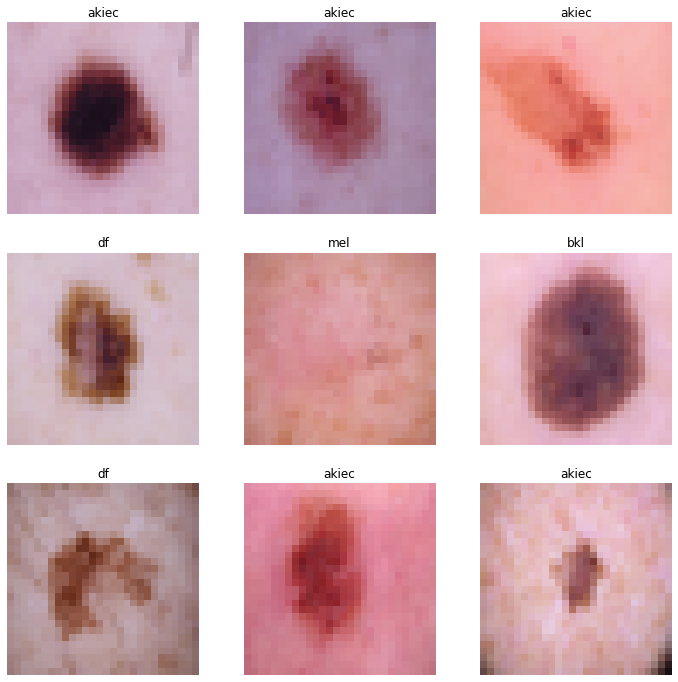

In [20]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(sample_X[i]))
    img_label = label_mapping[sample_y[i]]
    plt.title(img_label)
    plt.axis("off")

plt.show()

### Splitting into Train & Test

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.7, random_state=123)

In [22]:
Y_train = Y_train.values

In [23]:
Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))

In [24]:
Y_test = Y_test.values

In [25]:
Y_test = np.reshape(Y_test, (Y_test.shape[0], 1))

In [26]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 7010
number of test examples = 3005
X_train shape: (7010, 28, 28, 3)
Y_train shape: (7010, 1)
X_test shape: (3005, 28, 28, 3)
Y_test shape: (3005, 1)


## Building the model

In [30]:
def CancerModel(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2, 2), name='max_pool')(X)
    
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2, 2), name='max_pool2')(X)

    X = Flatten()(X)
    X = Dense(128, activation='relu', name='fc1')(X)
    X = Dropout(0.2)(X)    
    X = Dense(64, activation='relu', name='fc2')(X)
    X = Dropout(0.2)(X)    
    X = Dense(7, activation='softmax', name='output')(X)

    model = Model(inputs = X_input, outputs = X, name='CancerModel')

    return model

### Create the model

In [31]:
cancerModel = CancerModel(X_train.shape[1:])

### Compile the model

In [32]:
cancerModel.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

## Train the model

In [33]:
monitor = EarlyStopping(monitor='val_loss', 
                        min_delta=1e-3, 
                        patience=5, verbose=1, 
                        restore_best_weights=True)

history = cancerModel.fit(X_train, Y_train, 
                          validation_split = 0.25, 
                          epochs=200, batch_size=32, 
                          callbacks=[monitor])

Epoch 1/200
165/165 [==============================] - 3s 21ms/step - loss: 0.9924 - accuracy: 0.6675 - val_loss: 1.5177 - val_accuracy: 0.5727
Epoch 2/200
165/165 [==============================] - 3s 19ms/step - loss: 0.8518 - accuracy: 0.6924 - val_loss: 0.8790 - val_accuracy: 0.6977
Epoch 3/200
165/165 [==============================] - 3s 19ms/step - loss: 0.7903 - accuracy: 0.7091 - val_loss: 0.8896 - val_accuracy: 0.6811
Epoch 4/200
165/165 [==============================] - 3s 20ms/step - loss: 0.7672 - accuracy: 0.7253 - val_loss: 0.8090 - val_accuracy: 0.7125
Epoch 5/200
165/165 [==============================] - 3s 20ms/step - loss: 0.7263 - accuracy: 0.7344 - val_loss: 1.0002 - val_accuracy: 0.7022
Epoch 6/200
165/165 [==============================] - 3s 20ms/step - loss: 0.6867 - accuracy: 0.7483 - val_loss: 0.7409 - val_accuracy: 0.7365
Epoch 7/200
165/165 [==============================] - 3s 20ms/step - loss: 0.6653 - accuracy: 0.7624 - val_loss: 0.7770 - val_accuracy:

## Evaluate the model

In [34]:
preds = cancerModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

94/94 [==============================] - 1s 6ms/step - loss: 0.7626 - accuracy: 0.7251

Loss = 0.76255202293396
Test Accuracy = 0.7251247763633728


In [35]:
cancerModel.summary()

Model: "CancerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 32, 32, 3)         0         
_________________________________________________________________
conv (Conv2D)                (None, 30, 30, 16)        448       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 30, 30, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 15, 15, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 32)        

In [36]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Summarize history for Accuracy

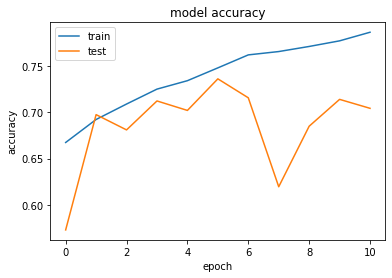

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Summarize history for Loss

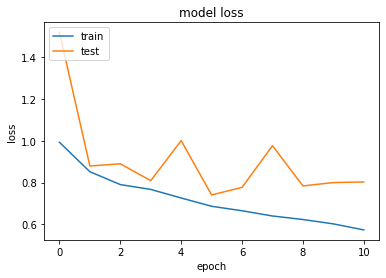

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Result

In [39]:
y_true = np.array(Y_test)

y_pred = cancerModel.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

In [40]:
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())

/Users/sparshbohra/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


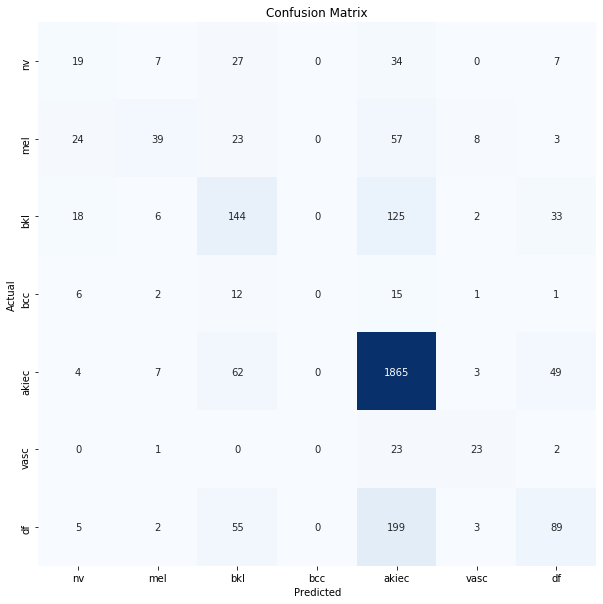

In [41]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')

plt.xticks(np.arange(7) + 0.5, label_mapping.values())
plt.xlabel("Predicted")

plt.yticks(np.arange(7) + 0.5, label_mapping.values())
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [42]:
print(clr)

              precision    recall  f1-score   support

          nv       0.25      0.20      0.22        94
         mel       0.61      0.25      0.36       154
         bkl       0.45      0.44      0.44       328
         bcc       0.00      0.00      0.00        37
       akiec       0.80      0.94      0.87      1990
        vasc       0.57      0.47      0.52        49
          df       0.48      0.25      0.33       353

    accuracy                           0.73      3005
   macro avg       0.45      0.36      0.39      3005
weighted avg       0.69      0.73      0.69      3005



## Test with single images

[[0.00470541 0.01188531 0.03096708 0.00888862 0.8974859  0.00767638
  0.03839113]]


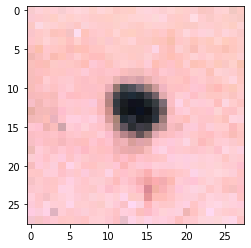

In [43]:
img_path = 'HAM10000_images_part_1/ISIC_0028290.jpg'

img = image.load_img(img_path, target_size=(28, 28))
imshow(img)

x = image.img_to_array(img)
x /= 255
x = x.reshape(1, 28, 28, 3)

final_prediction = cancerModel.predict(x)
print(final_prediction)

In [44]:
output_labels = ["Actinic Keratoses and Intraepithelial Carcinoma / Bowen's Disease (akiec)",
                 "Basal Cell Carcinoma (bcc)",
                 "Benign Keratosis-like Lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)",
                 "Dermatofibroma (df)",
                 "Melanocytic Nevi (nv)",
                 "Vascular Lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)",
                 "Melanoma (mel)"]
output_length = len(output_labels)

In [47]:
p = np.argmax(final_prediction[0])
print(output_labels[p])

Melanocytic Nevi (nv)


In [49]:
cancerModel.save('CancerClassifier_v1.h5')